# **Netflix Movies and TV Shows**

Author: Jiaxin Zheng

About the data: The dataset is from Kaggle. https://www.kaggle.com/datasets/shivamb/netflix-shows/data

Netflix is one of the most popular media and video streaming platforms. As of mid-2021, it had over 200 million subscribers globally and over 8,000 movies or TV shows.

This data set includes details of all the movies and TV shows available on Netflix, along with details of cast, directors, ratings, release year, duration, etc.

**Guiding Questions:**
1. Does Netflix have more focus on TV shows than movies in recent years?
2. What community structures emerge with the Netflix catalog?
3. What is the relationship between direct and actor?
4. What are the most common keywords?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re
import nltk
from collections import Counter
import itertools
!pip install squarify
import squarify
from networkx.algorithms import community, bipartite
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
url = 'https://raw.githubusercontent.com/Jennyjjxxzz/Data620_Final-Project/refs/heads/main/netflix_titles.csv'
df = pd.read_csv(url)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## **Q1: Does Netflix have more focus on TV shows than movies in recent years?**

#### **A. TV Shows Vs Movies Over time**

Since 2015, the number of movies added each year has surpassed that of TV shows. The number of movies peaked around 2018 to 2019, but declined afterward—likely due to the impact of the COVID-19 pandemic. In 2020 and beyond, movie and TV release counts have converged. May be Netflix has shifted its strategy toward TV shows.

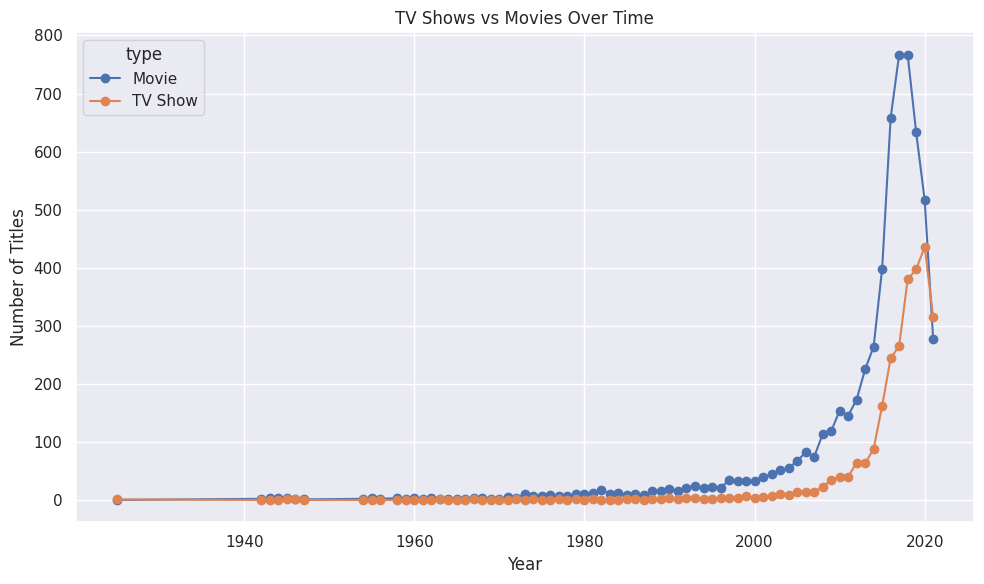

In [ ]:
df_time = df.dropna(subset=['release_year'])
df_time['release_year'] = df_time['release_year'].astype(int)
type_counts = df_time.groupby(['release_year', 'type']).size().unstack().fillna(0)
type_counts.plot(kind='line', figsize=(10,6), marker='o', title='TV Shows vs Movies Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

#### **B. Analysis of Movies vs TV shows**

Movies in Netflix are more than TV shows.

<ipython-input-153-440574463324>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="type", data=df, palette="Set2")


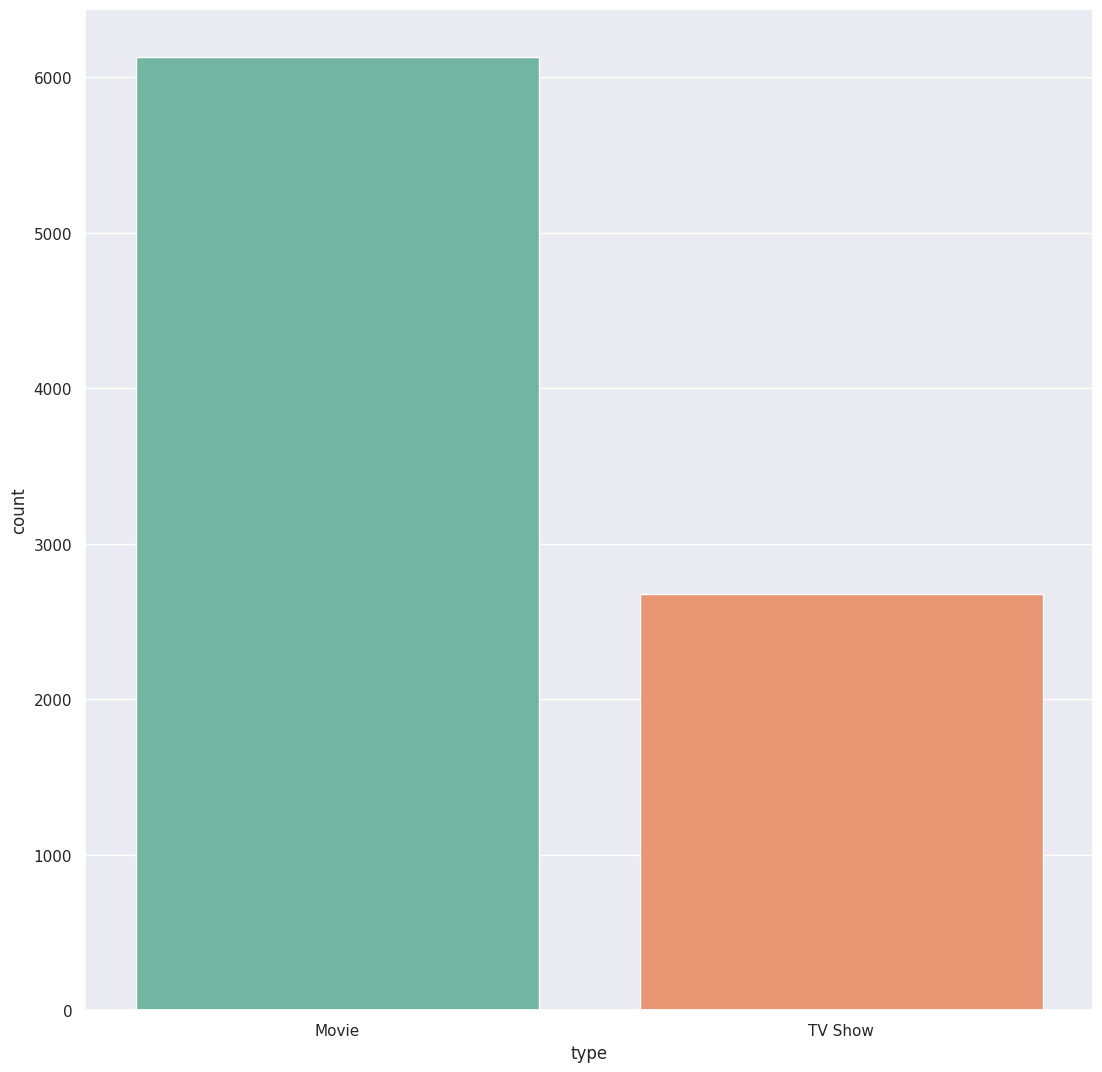

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="type", data=df, palette="Set2")

#### **C. Top 15 Genres on Netflix**

International Movies are the top one, followed by dramas and comedies.

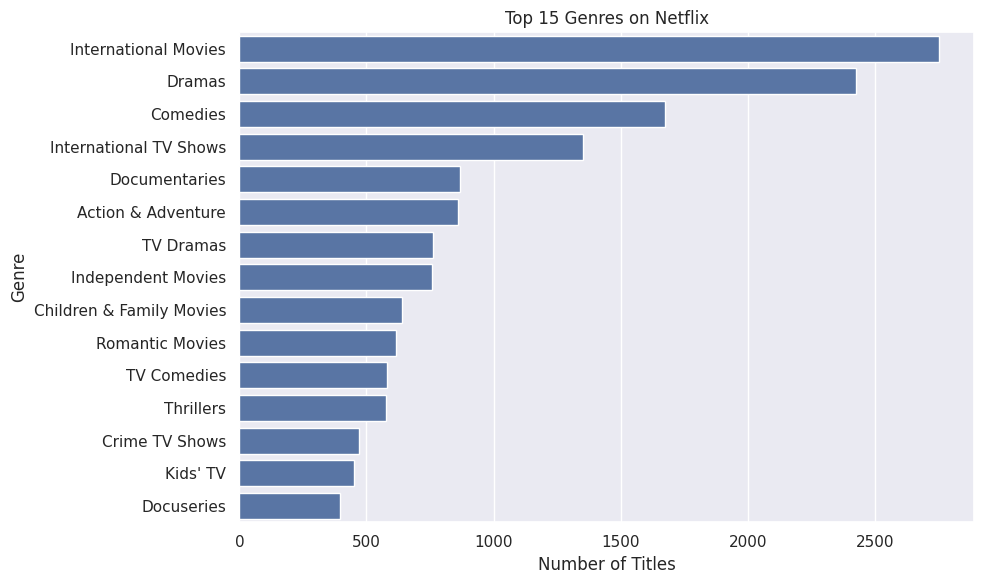

In [ ]:
df = df.dropna(subset=['title', 'listed_in'])

# Create a new column 'genres' that splits the 'listed_in' string into a list
df['genres'] = df['listed_in'].str.split(', ')
df[['title', 'genres']].head()
# Flatten all genres into a single list
all_genres = [genre for sublist in df['genres'] for genre in sublist]

# Count numbers
genre_counts = Counter(all_genres)
top_genres = genre_counts.most_common(15)

# Convert to DataFrame for plotting
genre_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Bar Plot
plt.figure(figsize=(10,6))
sns.barplot(y='Genre', x='Count', data=genre_df)
plt.title("Top 15 Genres on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

#### **D.Top 5 Countries in Terms of Movies Released**

The United States is the top country for movies released, followed by India.

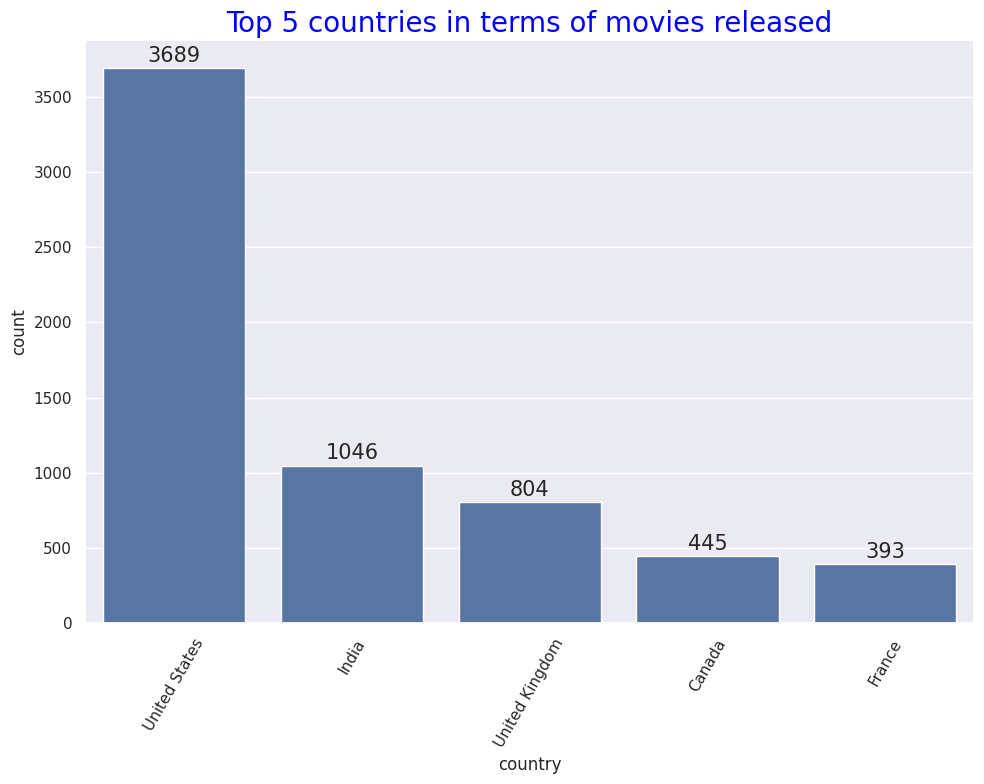

In [ ]:
title = 'Top 5 countries in terms of movies released'

# Count movies released number by country
countries = {}
for country in df.country.dropna():
    for sub_country in str(country).split(', '):
        countries[sub_country] = countries.get(sub_country, 0) + 1

# Create dataframe and sort the list
df_countries = pd.DataFrame(list(countries.items()), columns=['country', 'count'])
df_countries = df_countries.sort_values(by='count', ascending=False)

# Plot top 5 countries
plt.figure(figsize=(10, 8))
plt.xticks(rotation=60)
plt.title(title, color='blue', fontsize=20)

plots = sns.barplot(data=df_countries.head(5), x='country', y='count')

# Annotate bars
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='center',
                   size=15, xytext=(0, 9),
                   textcoords='offset points')

plt.tight_layout()
plt.show()

## **Q2: What community structures emerge with the Netflix catalog?**

#### **A. Top 5 Communities Networks**

When I link Netflix titles by shared actors and extract the five largest communities.

1. English Language Block: Community of U.S/ U.K produced films and series.

2. Spanish Language & European Sinema

3. Japanese Originals & Anime

4. Indonesian Horror & Dramas

5. African Film

Top 5 Communities:
 Community 1 (size=3002): ['Away', 'Popeye', 'Frontier', 'The Golden Child', 'The Book of Henry']
 Community 2 (size=1427): ['Mumbai Meri Jaan', 'Horror Story', 'Gun City', 'You vs. Wild: Out Cold', '4L']
 Community 3 (size=509): ['Akame ga Kill!', 'Yoko and His Friends', 'Midnight Diner', 'High & Low The Red Rain', 'Polly Pocket']
 Community 4 (size=389): ['The Family Court', 'The 3rd Eye 2', 'The Night Comes for Us', 'Just You', 'Dilan 1991']
 Community 5 (size=206): ['Anchor Baby', 'Blood & Water', 'Living in Bondage: Breaking Free', 'She Is', 'Alakada Reloaded']


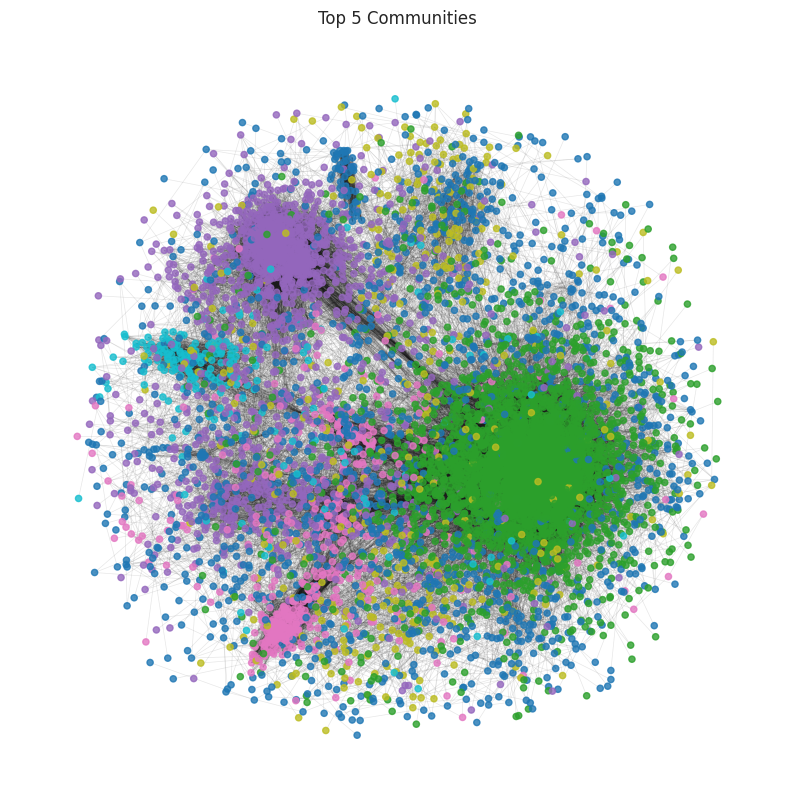

In [ ]:
cast_df = (
    df[['show_id','title','cast']]
      .dropna(subset=['cast'])
      .assign(cast_list=lambda d: d['cast'].str.split(','))
      .explode('cast_list')
)
cast_df['cast_list'] = cast_df['cast_list'].str.strip()

# Build the co-appearance graph
G = nx.Graph()
for actor, grp in cast_df.groupby('cast_list'):
    shows = grp['show_id'].tolist()
    # connect every pair of shows that share this actor
    for u, v in itertools.combinations(shows, 2):
        G.add_edge(u, v)

# Detect communities via greedy modularity
comms = list(community.greedy_modularity_communities(G_core))
# sort by size (descending) and take top 5
top5 = sorted(comms, key=len, reverse=True)[:5]

# Print out the top 5 communities
print("Top 5 Communities:")
for i, comm in enumerate(top5, start=1):
    sample = df.set_index('show_id').loc[list(comm), 'title'].unique()[:5]
    print(f" Community {i} (size={len(comm)}): {sample.tolist()}")

# Color-plot the core by community
comm_map = {}
for cid, comm in enumerate(top5, start=1):
    for node in comm:
        comm_map[node] = cid

colors = [comm_map.get(n, 0) for n in G_core.nodes()]
pos    = nx.spring_layout(G_core, k=0.12, seed=42)

plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(
    G_core, pos,
    node_size=20,
    node_color=colors,
    cmap=plt.cm.tab10,
    alpha=0.8
)
nx.draw_networkx_edges(G_core, pos, alpha=0.1, width=0.5)
plt.title("Top 5 Communities")
plt.axis('off')
plt.show()

#### **B.Top Genre Community**

The top genre community bundles Drama, Comedy, Family, Music, Romance, and War. Secondary TV-series

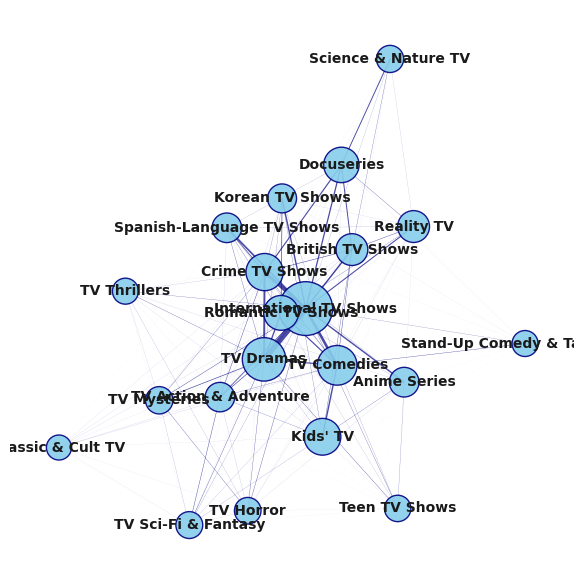

In [ ]:
# Detect the top communities
comms = list(community.greedy_modularity_communities(Gg, weight='weight'))
# sort by size descending and grab the first one
comm1 = sorted(comms, key=lambda c: len(c), reverse=True)[0]

# Build the Community-1 subgraph
subG1 = Gg.subgraph(comm1).copy()

# Create node sizes & edge widths
max_freq = max(genre_counts[g] for g in subG1.nodes())
node_sizes = [
    300 + (genre_counts[g] / max_freq) * 1200
    for g in subG1.nodes()
]

weights    = nx.get_edge_attributes(subG1, 'weight')
max_w      = max(weights.values())
edge_widths = [
    (weights[(u,v)] / max_w) * 4                # max thickness = 4
    for u,v in subG1.edges()
]


# Layout & plot
pos = nx.spring_layout(subG1, k=0.5, seed=42)

plt.figure(figsize=(6,6))
nx.draw_networkx_nodes(
    subG1, pos,
    node_size=node_sizes,
    node_color='skyblue',
    edgecolors='navy',
    linewidths=1.0,
    alpha=0.9
)
nx.draw_networkx_edges(
    subG1, pos,
    width=edge_widths,
    alpha=0.7,
    edge_color='navy'
)
nx.draw_networkx_labels(
    subG1, pos,
    font_size=10,
    font_weight='bold'
)

plt.axis('off')
plt.tight_layout()
plt.show()


## **Q3: What is the relationship between direct and actor?**

#### **A. Explode the collaboration between director and actors**

In [ ]:
# explode directors + cast
dir_df = (
    df[['show_id','director','cast']]
      .dropna()
      .assign(director=lambda d: d['director'].str.split(','))
      .explode('director')
      .assign(actor=lambda d: d['cast'].str.split(','))
      .explode('actor')
)
dir_df['director'] = dir_df['director'].str.strip()
dir_df['actor']    = dir_df['actor'].str.strip()

# build bipartite graph
B = nx.Graph()
B.add_nodes_from(dir_df['director'].unique(), bipartite='director')
B.add_nodes_from(dir_df['actor'].unique(),    bipartite='actor')
B.add_edges_from(dir_df[['director','actor']].itertuples(index=False, name=None))

# compute bipartite degree centrality
actor_cent    = bipartite.degree_centrality(B, dir_df['director'].unique())
director_cent = bipartite.degree_centrality(B, dir_df['actor'].unique())

print("\nTop 5 actors by director-collaborations:")
for name, c in sorted(actor_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {name}: {c:.3f}")

print("\nTop 5 directors by actor-collaborations:")
for name, c in sorted(director_cent.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {name}: {c:.3f}")


Top 5 actors by director-collaborations:
  Kristen Bell: 0.007
  Naseeruddin Shah: 0.007
  Radhika Apte: 0.006
  Anupam Kher: 0.006
  Kareena Kapoor: 0.006

Top 5 directors by actor-collaborations:
  Steven Spielberg: 0.028
  Anurag Kashyap: 0.020
  Don Michael Paul: 0.019
  Kunle Afolayan: 0.019
  Youssef Chahine: 0.019


#### **B. Identify the most director and actor collaborations**

In [ ]:
# identify actor vs. director nodes
actors   = [n for n,d in B.nodes(data=True) if d['bipartite']=='actor']
directors= [n for n,d in B.nodes(data=True) if d['bipartite']=='director']

# compute number of unique collaborators
actor_degrees    = {a: B.degree(a) for a in actors}
director_degrees = {d: B.degree(d) for d in directors}

# find the top one of each
top_actor    = max(actor_degrees,    key=actor_degrees.get)
top_director = max(director_degrees, key=director_degrees.get)

print(f"Actor with most director collaborations:  {top_actor}  →  worked with {actor_degrees[top_actor]} directors")
print(f"Director with most actor collaborations: {top_director}  →  worked with {director_degrees[top_director]} actors")


Actor with most director collaborations:  Steven Spielberg  →  worked with 116 directors
Director with most actor collaborations: Martin Scorsese  →  worked with 121 actors


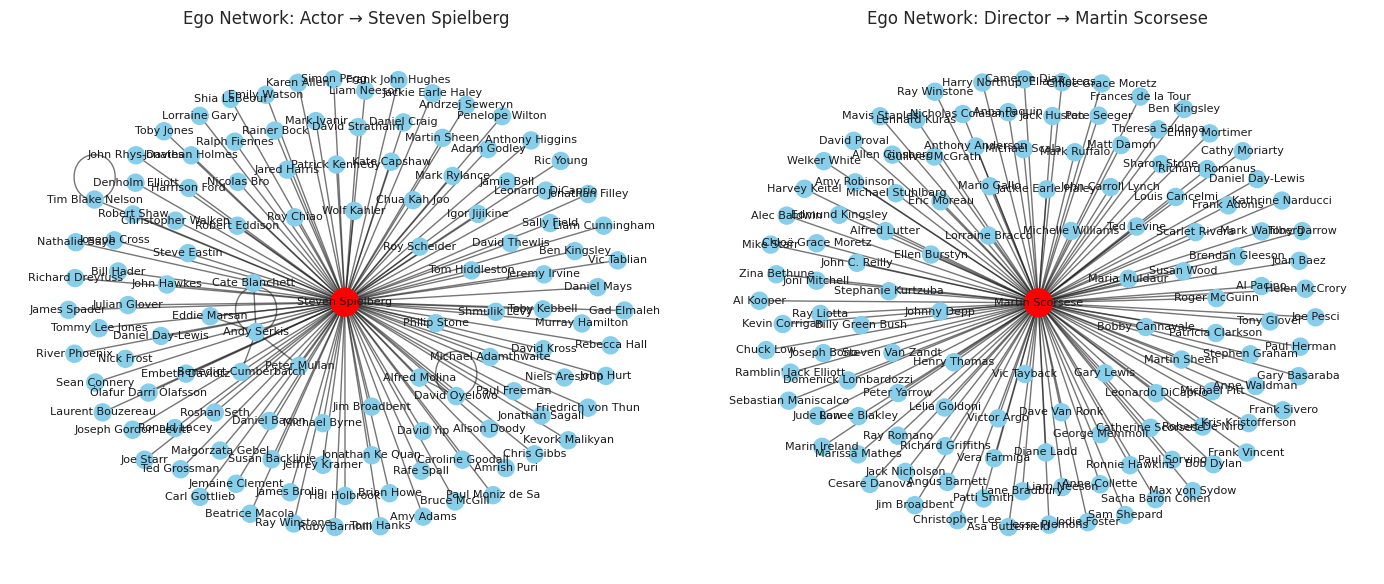

In [ ]:
# Extract each ego-network
ego_actor    = nx.ego_graph(B, top_actor)
ego_director = nx.ego_graph(B, top_director)

# Plot size
fig, axes = plt.subplots(1, 2, figsize=(14,6))

for ax, ego_net, center, title in [
    (axes[0], ego_actor,    top_actor,    f"Ego Network: Actor → {top_actor}"),
    (axes[1], ego_director, top_director, f"Ego Network: Director → {top_director}")
]:
    # layout
    pos = nx.spring_layout(ego_net, k=0.4, seed=42)

    # draw nodes: center in red, others in blue
    node_colors = ['red' if n==center else 'skyblue' for n in ego_net]
    node_sizes  = [400 if n==center else 150 for n in ego_net]

    nx.draw_networkx_nodes(ego_net, pos,
                           node_color=node_colors,
                           node_size=node_sizes,
                           ax=ax)
    nx.draw_networkx_edges(ego_net, pos,
                           alpha=0.6,
                           ax=ax)
    nx.draw_networkx_labels(ego_net, pos,
                            font_size=8,
                            ax=ax)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


## **Q4: What are the most common keywords?**

#### **A.Top 10 Keywords in Descriptions**

Descriptions are dominated by “life,” “new,” “young,” “family,” and “world”

Pointing to a narrative focus on youth, and family relationships.

In [ ]:
cv = CountVectorizer(max_features=20, stop_words='english')
X = cv.fit_transform(df['description'].fillna(''))
kw_counts = pd.Series(X.toarray().sum(axis=0), index=cv.get_feature_names_out())
print("\nQ4B: Top 10 Keywords in Descriptions:")
print(kw_counts.sort_values(ascending=False).head(10))


Q4B: Top 10 Keywords in Descriptions:
life       845
young      729
new        709
family     635
world      570
man        538
love       504
woman      486
friends    445
series     396
dtype: int64


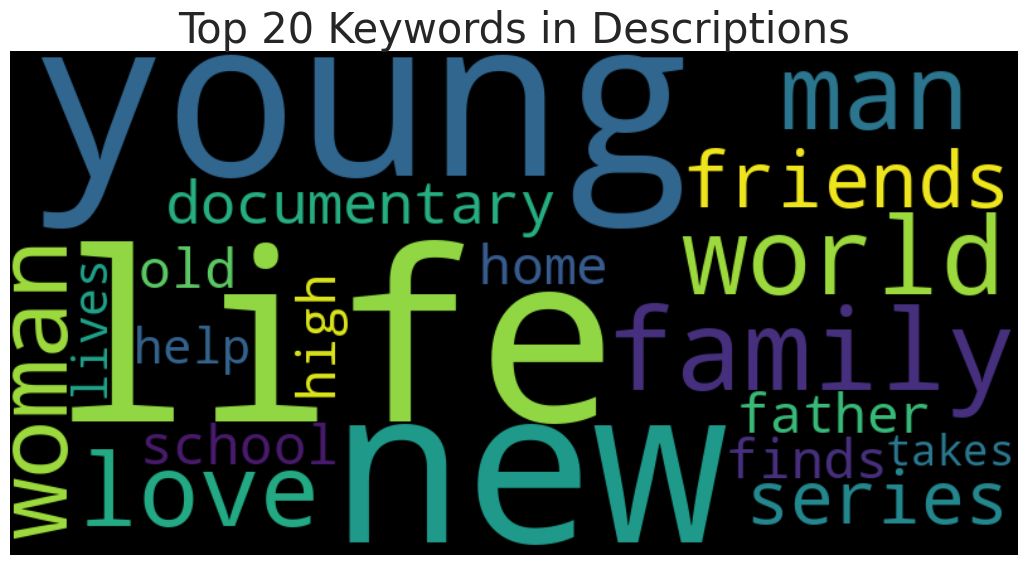

In [ ]:
plt.rcParams['figure.figsize'] = (13, 13)
all_text = " ".join(df['description'].fillna(''))
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='black',
    width=800,
    height=400,
    max_words=20
).generate_from_frequencies(kw_counts.to_dict())
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 Keywords in Descriptions', fontsize=30)
plt.show()


#### **B.Most Popular Words in Title**

Titles most often feature words like “love,” “man,” “girl,” “day,” and “Christmas”

Pointing to a narrative focus on relationship and emotional content.

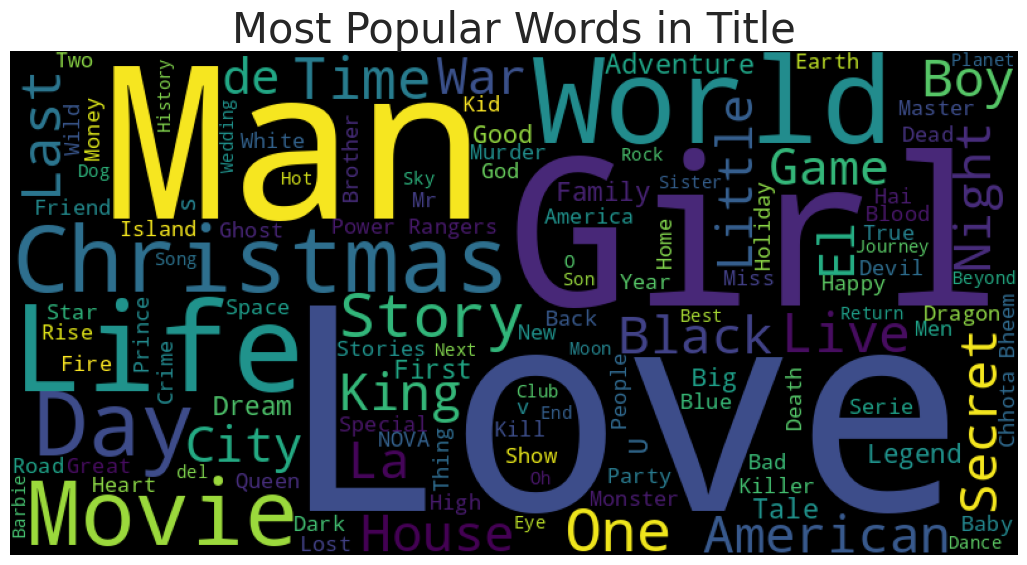

In [ ]:
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color = 'black',
    width = 800,
    height = 400,
    max_words = 121).generate(' '.join(df['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Words in Title',fontsize = 30)
plt.show()

## Conclusion:

- Shift to TV: Before 2020, Netflix added more movies each year; since 2020, TV shows have overtaken movies in annual additions.

- Five major communities: U.S/U.K, India, Latin/European, Japanese, and African

- Both titles and descriptions repeatedly feature “life,” “family,” “love,” and “world,” underscoring Netflix's focus on relationship and emotional storytelling

Global + Local: It shows Netflix combines global scale with locally cast, and genres to keep subscribers engaged.